In [1]:
from IPython.display import clear_output

In [2]:
!apt-get install gcc-4.8 gcc-5 g++-4.8 g++-5
!apt-get install libblas-dev liblapack-dev
!apt-get install libopenblas-dev
!apt-get install gfortran-4.8
!apt-get install gfortran-5
!apt-get install scons
!apt-get install libpng-dev
!apt-get install libboost-all-dev freeglut3-dev
!apt-get install xvfb
!apt-get install libspatialindex-dev
clear_output()

In [3]:
!pip install torch==1.3.0 rtree trimesh
clear_output()

In [4]:
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-4.8 10
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-5 20
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-4.8 10
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-5 20
clear_output()

In [5]:
%cd /content

/content


In [6]:
!git clone https://github.com/mszarski/diffsim.git

Cloning into 'diffsim'...
remote: Enumerating objects: 1209, done.
remote: Counting objects: 100% (1209/1209), done.
remote: Compressing objects: 100% (786/786), done.
remote: Total 1209 (delta 427), reused 1056 (delta 301), pack-reused 0
Receiving objects: 100% (1209/1209), 27.80 MiB | 19.66 MiB/s, done.
Resolving deltas: 100% (427/427), done.


In [7]:
!chmod +x diffsim/arcsim/dependencies/taucs/configure

In [8]:
%cd /content

/content


In [9]:
%cd diffsim
!update-alternatives --set gcc "/usr/bin/gcc-4.8"
!update-alternatives --set g++ "/usr/bin/g++-4.8"
%cd arcsim/dependencies/
!make 
%cd ../..
!update-alternatives --set gcc "/usr/bin/gcc-5"
!update-alternatives --set g++ "/usr/bin/g++-5"
!make -j 8
%cd pysim
!ln -s ../arcsim/conf ./conf
!ln -s ../arcsim/materials ./materials
!ln -s ../arcsim/meshes ./meshes

clear_output()

In [ ]:
##restart runtime here

In [1]:
%cd /content/diffsim/pysim

/content/diffsim/pysim


In [2]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/draping_workspace'       # path to your project on Drive

drive.mount(ROOT)

Mounted at /content/drive


In [2]:
inital_fabric_mesh_path = "/content/drive/My Drive/draping_workspace/apb_mm_flatmesh_simplified_2.obj"
tool_mesh_path = "/content/drive/My Drive/draping_workspace/apb_mm_simplified_2.obj"
handles = [92,31, 118,67]


boundary = [ 16,  62,  98, 100,  14, 117,  31,  85,  55,  68, 108,   5,  45,
         74,  83, 127,  67,  84,  33, 132, 111, 118,   9,  93, 123,  44,
         58,  43, 113,   3,  22,  92,  79,  87,  78, 130]


fabric_t = [-0.1,-0.3,0.0]
tool_t = [-0.1,-0.3,-0.5]
scale = 0.01
seed_pt_idx = 61 #middle
# seed_pt_idx = 132 #short end
# seed_pt_idx = 62 #long end


In [3]:
import trimesh
import trimesh.transformations as tf
import numpy as np

curved_mesh = trimesh.load(tool_mesh_path,process=False)
flat_mesh = trimesh.load(inital_fabric_mesh_path,process=False)
scene = trimesh.Scene(base_frame='world')

curved_mesh.apply_scale(scale)
flat_mesh.apply_scale(scale)

transform = tf.translation_matrix(fabric_t)
flat_mesh.apply_transform(transform)
f_id = scene.add_geometry(flat_mesh)


transform = tf.translation_matrix(tool_t)
curved_mesh.apply_transform(transform)
c_id = scene.add_geometry(curved_mesh)

#scene.show()

In [4]:
import networkx as nx
import torch
import itertools

torch_curved_v = torch.tensor(curved_mesh.vertices,dtype=torch.float64)
torch_tool_v = torch.tensor(curved_mesh.vertices, dtype=torch.float64)
torch_tool_n = torch.tensor(curved_mesh.vertex_normals, dtype=torch.float64)

#precalculate all pairs shortest paths
G = nx.Graph()
G.add_edges_from(flat_mesh.edges_unique)
P = dict(nx.all_pairs_shortest_path(G))

def calculate_rings(seed_pt_idx, boundary):
    rings = []
    rings.append([seed_pt_idx])
    while True:
        next_ring = [list(G[i].keys()) for i in rings[-1]]
        next_ring_no_center = set(itertools.chain(*next_ring)) - set(itertools.chain(*rings))
        rings.append(list(next_ring_no_center))
        if set(boundary) <= set(itertools.chain(*rings)):
            return rings[1:]

rings = calculate_rings(seed_pt_idx, boundary)

def ring_contact_loss_normal(sim, rings,thresh = 5e-3):

    dists = []
    for i in range(len(sim.cloths[0].mesh.nodes)):
        dists.append(torch.dot(sim.cloths[0].mesh.nodes[i].x - torch_tool_v[i],torch_tool_n[i]))

    #n_dists = torch.einsum('ij,ij->i', torch_fabric_v - torch_tool_v, torch_tool_n)

    n_dists = torch.stack(dists)
    pos_n_dists = torch.nn.functional.relu(n_dists)
    # weights = torch.exp(-pos_n_dists/thresh)

    ring_weights = np.linspace(10,0,len(rings))

    contact = torch.tensor(0.0)

    for i in range(len(rings)):
        contact += pos_n_dists[rings[i]].mean()*ring_weights[i]

    return contact

def total_contact_loss_dist_normal(sim, exclude_indices = None, thresh = 5e-3):

    if exclude_indices is None: 
        exclude_indices = []

    one_rings = [list(G[i].keys()) for i in exclude_indices]
    exclude_indices.append(list(itertools.chain(*one_rings)))

    dists = []
    for i in range(len(sim.cloths[0].mesh.nodes)):
        if not i in exclude_indices:
            dists.append(torch.dot(sim.cloths[0].mesh.nodes[i].x - torch_tool_v[i],torch_tool_n[i]))

    n_dists = torch.stack(dists)

    pos_z_dists = torch.nn.functional.relu(n_dists)
    # contact_loss = torch.mean(torch.exp(-pos_z_dists/thresh))

    contact_loss = torch.mean(pos_z_dists)

    return contact_loss

In [5]:
#https://raw.githubusercontent.com/akanazawa/cmr/master/nnutils/laplacian.py

"""
Computes Lx and it's derivative, where L is the graph laplacian on the mesh with cotangent weights.

1. Given V, F, computes the cotangent matrix (for each face, computes the angles) in pytorch.
2. Then it's taken to NP and sparse L is constructed.

Mesh laplacian computation follows Alec Jacobson's gptoolbox.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
from torch.autograd import Variable

import numpy as np
from scipy import sparse

#############
### Utils ###
#############
def convert_as(src, trg):
    src = src.type_as(trg)
    if src.is_cuda:
        src = src.cuda(device=trg.get_device())
    return src

########################################################################
################# Wrapper class for a  PythonOp ########################
##### All functions must only use torch Tensors as inputs/outputs ######
########################################################################
class Laplacian(torch.autograd.Function):
    def __init__(self, faces):
        # Faces is B x F x 3, cuda torch Variabe.
        # Reuse faces.
        self.F_np = faces.data.cpu().numpy()
        self.F = faces.data
        self.L = None

    def forward(self, V):
        # If forward is explicitly called, V is still a Parameter or Variable
        # But if called through __call__ it's a tensor.
        # This assumes __call__ was used.
        #
        # Input:
        #   V: B x N x 3
        #   F: B x F x 3
        # Outputs: Lx B x N x 3
        #
        # Numpy also doesnt support sparse tensor, so stack along the batch

        V_np = V.cpu().detach().numpy()
        batchV = V_np.reshape(-1, 3)

        if self.L is None:
            # print('Computing the Laplacian!')
            # Compute cotangents
            C = cotangent(V, self.F)
            C_np = C.cpu().numpy()
            batchC = C_np.reshape(-1, 3)            
            # Adjust face indices to stack:
            offset = np.arange(0, V.size(0)).reshape(-1, 1, 1) * V.size(1)
            F_np = self.F_np + offset
            batchF = F_np.reshape(-1, 3)

            rows = batchF[:, [1, 2, 0]].reshape(-1)
            cols = batchF[:, [2, 0, 1]].reshape(-1)
            # Final size is BN x BN
            BN = batchV.shape[0]
            L = sparse.csr_matrix((batchC.reshape(-1), (rows, cols)), shape=(BN,BN))
            L = L + L.T
            # np.sum on sparse is type 'matrix', so convert to np.array
            M = sparse.diags(np.array(np.sum(L, 1)).reshape(-1), format='csr')
            L = L - M
            # remember this
            self.L = L
            # import matplotlib.pylab as plt
            # plt.ion()
            # plt.clf()
            # plt.spy(L)
            # plt.show()
            # import ipdb; ipdb.set_trace()

        Lx = self.L.dot(batchV).reshape(V_np.shape)

        return convert_as(torch.Tensor(Lx), V)

    def backward(self, grad_out):
        """
        Just L'g = Lg
        Args:
           grad_out: B x N x 3
        Returns:
           grad_vertices: B x N x 3
        """
        g_o = grad_out.cpu().numpy()
        # Stack
        g_o = g_o.reshape(-1, 3)
        Lg = self.L.dot(g_o).reshape(grad_out.shape)

        return convert_as(torch.Tensor(Lg), grad_out)


def cotangent(V, F):
    # Input:
    #   V: B x N x 3
    #   F: B x F  x3
    # Outputs:
    #   C: B x F x 3 list of cotangents corresponding
    #     angles for triangles, columns correspond to edges 23,31,12

    # B x F x 3 x 3
    indices_repeat = torch.stack([F, F, F], dim=2)

    v1 = torch.gather(V, 1, indices_repeat[:, :, :, 0])
    v2 = torch.gather(V, 1, indices_repeat[:, :, :, 1])
    v3 = torch.gather(V, 1, indices_repeat[:, :, :, 2])
    
    l1 = torch.sqrt(((v2 - v3)**2).sum(2))
    l2 = torch.sqrt(((v3 - v1)**2).sum(2))
    l3 = torch.sqrt(((v1 - v2)**2).sum(2))

    # semiperimieters
    sp = (l1 + l2 + l3) * 0.5

    # Heron's formula for area
    A = 2*torch.sqrt( sp * (sp-l1)*(sp-l2)*(sp-l3))

    cot23 = (l2**2 + l3**2 - l1**2)
    cot31 = (l1**2 + l3**2 - l2**2)
    cot12 = (l1**2 + l2**2 - l3**2)

    # 2 in batch
    C = torch.stack([cot23, cot31, cot12], 2) / torch.unsqueeze(A, 2) / 4

    return C

def laplacian_loss_fn(sim):

    lp = Laplacian(torch.tensor(curved_mesh.faces).unsqueeze(0))

    vs = []
    for i in range(len(sim.cloths[0].mesh.nodes)):
        vs.append(sim.cloths[0].mesh.nodes[i].x)

    vs = torch.stack(vs).unsqueeze(0)

    Lx = lp(vs)
    Lx = Lx.view(-1, Lx.size(2))
    loss = torch.norm(Lx, p=2, dim=1).mean()

    return loss

In [6]:
import arcsim
import json
import os

def run(phase_config):
  torch.manual_seed(0)
  np.random.seed(0)
  torch.set_num_threads(8)

  if not os.path.exists(phase_config['out_path']):
    os.mkdir(phase_config['out_path'])

  config = json.loads(phase_config['json_config'])

  with open(phase_config['out_path']+'/conf.json','w') as f:
    json.dump(config, f)

  sim=arcsim.get_sim()

  param_v = torch.zeros([phase_config['steps'], 4,3],dtype=torch.float64, requires_grad=True)

  optimizer = torch.optim.Adam([param_v],phase_config['lr'])
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

  best_loss = 1e30
  best_epoch = 0

  epoch = 0
  while True:

    if epoch < phase_config['epochs']:
      arcsim.init_physics(phase_config['out_path']+'/conf.json', phase_config['out_path']+'/out%d'%epoch,False)
    else:
      arcsim.init_physics(phase_config['out_path']+'/conf.json',phase_config['out_path']+'/out',False)

    optimizer.zero_grad()

    loss = phase_config['run_sim'](sim, param_v, phase_config['pre_steps'], phase_config['steps'])

    loss.backward(retain_graph=True)

    if loss.item() < best_loss:
      best_loss = loss.item()
      best_epoch = epoch
      torch.save(param_v, 'best_params.pt')
      print('new best')

    optimizer.step()

    arcsim.delete_mesh(sim.cloths[0].mesh)

    scheduler.step(loss.item())

    if epoch>=phase_config['epochs']:
      break
    epoch = epoch + 1

  return torch.load('best_params.pt'), best_epoch


In [7]:
def phase1_sim(sim,param_v, pre_steps, steps):

  seed_pt_losses = []
  contact_losses = []
  step_seed_pt_contact_losses = []

  print("step")
  for step in range(pre_steps + steps):

    if step > pre_steps-1:
      for i in range(len(handles)):
        sim.cloths[0].mesh.nodes[handles[i]].v += param_v[step-pre_steps,i] #* spf
  
      step_seed_pt_dist = torch.dot(sim.cloths[0].mesh.nodes[seed_pt_idx].x - torch_tool_v[seed_pt_idx],torch_tool_n[seed_pt_idx])
      n_dist = torch.nn.functional.relu(step_seed_pt_dist)
      thresh = 5e-3
      step_seed_pt_contact_loss = -torch.sum(torch.exp(-n_dist/thresh))
      step_seed_pt_contact_losses.append(step_seed_pt_contact_loss)

      step_seed_pt_loss = torch.norm(sim.cloths[0].mesh.nodes[seed_pt_idx].x - sim.obstacles[0].curr_state_mesh.nodes[seed_pt_idx].x)
      seed_pt_losses.append(step_seed_pt_loss)

      step_contact_loss = -total_contact_loss_dist_normal(sim,[seed_pt_idx],5e-3)
      contact_losses.append(step_contact_loss)

    arcsim.sim_step()

  contact_loss_steps = torch.stack(contact_losses,dim=0)
  contact_loss = torch.sum(contact_loss_steps)

  step_seed_pt_contact_loss_steps = torch.stack(step_seed_pt_contact_losses,dim=0)
  seed_pt_contact_loss = -torch.logsumexp(-step_seed_pt_contact_loss_steps*1000,0)/1000
         
  seed_pt_loss_steps = torch.stack(seed_pt_losses,dim=0)
  seed_pt_loss = torch.sum(seed_pt_loss_steps)

  print(f"contact loss: {contact_loss}, seed_pt_loss: {seed_pt_loss} seed_pt_contact_loss: {seed_pt_contact_loss}")

  total_loss = seed_pt_loss + seed_pt_contact_loss + contact_loss
  
  return total_loss


def phase2_sim(sim,param_v, pre_steps, steps):

  boundary_losses = []
  contact_losses = []
  laplacian_losses = []

  print("step")
  for step in range(pre_steps + steps):

    if step > pre_steps-1:
      for i in range(len(handles)):
        sim.cloths[0].mesh.nodes[handles[i]].v += param_v[step-pre_steps,i] #* spf
  
      step_contact_loss = ring_contact_loss_normal(sim,rings)
      contact_losses.append(step_contact_loss)

      loss_idxs = [*handles]
      step_boundary_loss = torch.tensor(0.0)
      for i in loss_idxs:
        w = 1
        step_boundary_loss += w*torch.norm(sim.cloths[0].mesh.nodes[i].x - sim.obstacles[0].curr_state_mesh.nodes[i].x)

      boundary_losses.append(step_boundary_loss)
      laplacian_losses.append(laplacian_loss_fn(sim))

    arcsim.sim_step()

  laplacian_loss_steps = torch.stack(laplacian_losses,dim=0)
  laplacian_loss = torch.mean(laplacian_loss_steps)

  contact_loss_steps = torch.stack(contact_losses,dim=0)
  contact_loss = torch.mean(contact_loss_steps)
         
  boundary_loss_steps = torch.stack(boundary_losses,dim=0)
  boundary_loss = torch.mean(boundary_loss_steps)

  boundary_loss = boundary_loss*10

  contact_loss = contact_loss*1

  laplacian_loss = laplacian_loss * 10

  print(f"contact loss: {contact_loss}, boundary_loss: {boundary_loss}, laplacian_loss: {laplacian_loss}")

  total_loss = boundary_loss + contact_loss + laplacian_loss

  return total_loss

def phase3_sim(sim,param_v, pre_steps, steps):

  phase1 = torch.load('phase1.pt')
  phase2 = torch.load('phase2.pt')
  param_v = torch.cat([phase1,phase2],dim=0)

  positions = np.zeros((steps,4,3),dtype=np.float64)

  print("step")
  for step in range(pre_steps + steps):

    if step > pre_steps-1:
      for i in range(len(handles)):
        sim.cloths[0].mesh.nodes[handles[i]].v += param_v[step-pre_steps,i] #* spf
        positions[step-pre_steps,i] = sim.cloths[0].mesh.nodes[handles[i]].x.detach().numpy()
  
    arcsim.sim_step()

  np.save('positions.npy', positions)
  return torch.norm(sim.cloths[0].mesh.nodes[seed_pt_idx].x - torch_tool_v[i])

In [9]:
phase1_config = {
    'lr':0.02,
    'run_sim':phase1_sim,
    'epochs':30,
    'pre_steps':5,
    'steps':20,
    'out_path' : '/content/double_hump_draping_phase1_out',
    'json_config' : f"""
    {{
    "frame_time": 0.125,
    "frame_steps": 1,
    "end_time": 10,
    "cloths": [
    {{
        "mesh": "{inital_fabric_mesh_path}",
        "transform":{{"scale":{scale},"translate":{fabric_t}}},
        "materials": [{{"data": "materials/gray-interlock.json",
                       "thicken": 2}}]
    }}
    ],
    "obstacles": [
    {{
        "mesh": "{tool_mesh_path}",
        "transform":{{"scale":{scale},"translate":{tool_t}}},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }}
    ],
    "disable":["remeshing", "proximity"],
    "handles": [{{"nodes": {handles}}}],
    "gravity":[0, 0, -9.8],
    "magic": {{"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}}
    }}"""
}

In [10]:
phase1_v, best_epoch = run(phase1_config)
torch.save(phase1_v, 'phase1.pt')
if best_epoch == phase1_config['epochs']:
  best_epoch = ""

step
contact loss: -6.453198583766804, seed_pt_loss: 5.4505715866861815 seed_pt_contact_loss: -0.002995732273554008
new best
step
contact loss: -6.008415580248191, seed_pt_loss: 4.5853063177546405 seed_pt_contact_loss: -0.0029957323454321764
new best
step
contact loss: -5.7121610464352095, seed_pt_loss: 3.8940223816119732 seed_pt_contact_loss: -0.0029983102095081527
new best
step
contact loss: -5.488093316770906, seed_pt_loss: 3.343176936042133 seed_pt_contact_loss: -0.008013904045557045
new best
step
contact loss: -5.291865974958944, seed_pt_loss: 2.9171191952395112 seed_pt_contact_loss: -0.6940411644350337
new best
step
contact loss: -5.130166546640856, seed_pt_loss: 2.8246531376645097 seed_pt_contact_loss: -0.5986613559391054
step
contact loss: -5.038160795538324, seed_pt_loss: 2.6409499492394013 seed_pt_contact_loss: -0.765344985357837
new best
step
contact loss: -5.01301870900819, seed_pt_loss: 2.4622295280279944 seed_pt_contact_loss: -0.8276171403963328
new best
step
contact loss

In [11]:
phase2_config = {
    'lr':0.04,
    'run_sim':phase2_sim,
    'epochs':60,
    'pre_steps':0,
    'steps':20,
    'out_path' : '/content/double_hump_draping_phase2_out',
    'json_config' : f"""
    {{
    "frame_time": 0.125,
    "frame_steps": 1,
    "end_time": 10,
    "cloths": [
    {{
        "mesh": "/content/double_hump_draping_phase1_out/out{best_epoch}/0025_000.obj",
        "materials": [{{"data": "materials/gray-interlock.json",
                       "thicken": 2}}]
    }}
    ],
    "obstacles": [
    {{
        "mesh": "{tool_mesh_path}",
        "transform":{{"scale":{scale},"translate":{tool_t}}},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }}
    ],
    "disable":["remeshing", "proximity"],
    "handles": [{{"nodes": {handles}}}],
    "gravity":[0, 0, -9.8],
    "magic": {{"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}}
    }}"""
}

In [12]:
phase2_v, epoch = run(phase2_config)
torch.save(phase2_v, 'phase2.pt')

step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 6.070534706115723, boundary_loss: 21.602746963500977, laplacian_loss: 0.9666296304269959
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 5.044526100158691, boundary_loss: 18.557966232299805, laplacian_loss: 0.926580008401384
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 4.321547985076904, boundary_loss: 16.74843978881836, laplacian_loss: 0.8895558486243798
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 3.8178601264953613, boundary_loss: 15.106002807617188, laplacian_loss: 0.8577676684950563
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 3.3185806274414062, boundary_loss: 13.699762344360352, laplacian_loss: 0.8330432430284276
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 3.019864082336426, boundary_loss: 12.457594871520996, laplacian_loss: 0.819944964991455
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.8649277687072754, boundary_loss: 11.784533500671387, laplacian_loss: 0.808893057674903
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.8558430671691895, boundary_loss: 11.361347198486328, laplacian_loss: 0.8172598716966804
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.822138786315918, boundary_loss: 10.974666595458984, laplacian_loss: 0.8353798204629079
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.343860149383545, boundary_loss: 10.670368194580078, laplacian_loss: 0.790263365017096
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.2820229530334473, boundary_loss: 10.464821815490723, laplacian_loss: 0.780931994039633
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.2311718463897705, boundary_loss: 11.742265701293945, laplacian_loss: 0.7923919531740959
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.1115670204162598, boundary_loss: 10.599693298339844, laplacian_loss: 0.7680581285686859
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.111128330230713, boundary_loss: 10.526376724243164, laplacian_loss: 0.7888109982414735
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.068223476409912, boundary_loss: 10.973011016845703, laplacian_loss: 0.7737693815758471
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.9984395503997803, boundary_loss: 10.234609603881836, laplacian_loss: 0.7816690058883904
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.9082502126693726, boundary_loss: 10.7777099609375, laplacian_loss: 0.7792228394122908
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.9369261264801025, boundary_loss: 10.514174461364746, laplacian_loss: 0.7809155765591403
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.8762118816375732, boundary_loss: 10.192933082580566, laplacian_loss: 0.7555367833818937
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.8783953189849854, boundary_loss: 10.162168502807617, laplacian_loss: 0.7629843493637642
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.9637359380722046, boundary_loss: 10.180252075195312, laplacian_loss: 0.7910466847060472
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.9333021640777588, boundary_loss: 9.932587623596191, laplacian_loss: 0.7921177681733511
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.879961371421814, boundary_loss: 9.837465286254883, laplacian_loss: 0.8112986516314792
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.7969906330108643, boundary_loss: 9.712726593017578, laplacian_loss: 0.7883989557535064
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.7542898654937744, boundary_loss: 9.627335548400879, laplacian_loss: 0.7924759520546885
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.731433629989624, boundary_loss: 9.686023712158203, laplacian_loss: 0.8021009578452877
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.7033898830413818, boundary_loss: 9.604584693908691, laplacian_loss: 0.8019984529841266
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.685704231262207, boundary_loss: 9.78589916229248, laplacian_loss: 0.7778492505876968
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.6762670278549194, boundary_loss: 9.711573600769043, laplacian_loss: 0.7802273281549045
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.658017873764038, boundary_loss: 9.773686408996582, laplacian_loss: 0.7688115374234337
Epoch    29: reducing learning rate of group 0 to 2.0000e-02.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.661604642868042, boundary_loss: 9.432246208190918, laplacian_loss: 0.8009236559114639
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.6288639307022095, boundary_loss: 9.365682601928711, laplacian_loss: 0.773114028743535
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.626267433166504, boundary_loss: 9.337772369384766, laplacian_loss: 0.7755250297120961
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.6372467279434204, boundary_loss: 9.32559871673584, laplacian_loss: 0.7740003570729874
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.6068203449249268, boundary_loss: 9.269925117492676, laplacian_loss: 0.7874789321550135
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.6166222095489502, boundary_loss: 9.249354362487793, laplacian_loss: 0.7991378406196412
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.6187156438827515, boundary_loss: 9.25898551940918, laplacian_loss: 0.7982137234316768
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.6024377346038818, boundary_loss: 9.184917449951172, laplacian_loss: 0.7885245809977206
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.6270654201507568, boundary_loss: 9.053114891052246, laplacian_loss: 0.8027672697419957
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.6490888595581055, boundary_loss: 9.044520378112793, laplacian_loss: 0.799373273619029
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.6689293384552002, boundary_loss: 9.067195892333984, laplacian_loss: 0.7916766796722362
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.684556245803833, boundary_loss: 9.00792121887207, laplacian_loss: 0.8086611870460758
Epoch    41: reducing learning rate of group 0 to 1.0000e-02.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.6764224767684937, boundary_loss: 9.000866889953613, laplacian_loss: 0.8106923015162614
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.6949188709259033, boundary_loss: 9.005375862121582, laplacian_loss: 0.8053518116252765
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.7153189182281494, boundary_loss: 8.992151260375977, laplacian_loss: 0.8054998764011543
Epoch    44: reducing learning rate of group 0 to 5.0000e-03.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.6722910404205322, boundary_loss: 8.927584648132324, laplacian_loss: 0.7919139293004009
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.7121467590332031, boundary_loss: 8.911849021911621, laplacian_loss: 0.828836331003302
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.698620080947876, boundary_loss: 8.883716583251953, laplacian_loss: 0.8481810840933293
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.698957085609436, boundary_loss: 8.90886116027832, laplacian_loss: 0.8206605953660574
Epoch    48: reducing learning rate of group 0 to 2.5000e-03.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.691819429397583, boundary_loss: 8.859601974487305, laplacian_loss: 0.8239051041383794
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.671600580215454, boundary_loss: 8.844037055969238, laplacian_loss: 0.7915591912063336
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.6728016138076782, boundary_loss: 8.84472370147705, laplacian_loss: 0.7940149123653434
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.68130362033844, boundary_loss: 8.821846008300781, laplacian_loss: 0.8065177870794342
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.6839641332626343, boundary_loss: 8.833930969238281, laplacian_loss: 0.8067275450726887
Epoch    53: reducing learning rate of group 0 to 1.2500e-03.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.7032591104507446, boundary_loss: 8.834033966064453, laplacian_loss: 0.8627480180983372
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.713922142982483, boundary_loss: 8.815291404724121, laplacian_loss: 0.8695482752170378
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.72470223903656, boundary_loss: 8.831645011901855, laplacian_loss: 0.8731226046864594
Epoch    56: reducing learning rate of group 0 to 6.2500e-04.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.7166576385498047, boundary_loss: 8.83346176147461, laplacian_loss: 0.8723694409885867
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.7179800271987915, boundary_loss: 8.824689865112305, laplacian_loss: 0.8729137562276856
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.7066450119018555, boundary_loss: 8.806966781616211, laplacian_loss: 0.868993996437256
Epoch    59: reducing learning rate of group 0 to 3.1250e-04.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 1.712024450302124, boundary_loss: 8.80693244934082, laplacian_loss: 0.870022360853149


In [8]:
phase3_config = {
    'lr':0.01,
    'run_sim':phase3_sim,
    'epochs':0,
    'pre_steps':5,
    'steps':40,
    'out_path' : '/content/double_hump_draping_phase3_out',
    'json_config' : f"""
    {{
    "frame_time": 0.125,
    "frame_steps": 1,
    "end_time": 10,
    "cloths": [
    {{
        "mesh": "{inital_fabric_mesh_path}",
        "transform":{{"scale":{scale},"translate":{fabric_t}}},
        "materials": [{{"data": "materials/gray-interlock.json",
                       "thicken": 2}}]
    }}
    ],
    "obstacles": [
    {{
        "mesh": "{tool_mesh_path}",
        "transform":{{"scale":{scale},"translate":{tool_t}}},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }}
    ],
    "disable":["remeshing", "proximity"],
    "handles": [{{"nodes": {handles}}}],
    "gravity":[0, 0, -9.8],
    "magic": {{"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}}
    }}"""
}

In [9]:
_ = run(phase3_config)
phase3_v = torch.cat([phase1_v,phase2_v],dim=0)

step
new best


NameError: ignored

In [39]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [40]:
vis_directory = '/content/double_hump_draping_phase3_out/out'

In [41]:
%%writetemplate visualize.py
import torch
import arcsim

with torch.autograd.profiler.profile() as prof:
	  arcsim.msim(4,['arcsim','replay','{vis_directory}', '45.0'])
print(prof)

main
4
arcsim replay /content/double_hump_draping_phase3_out/out
reply 1 
reply 2 
reply 3 
reply 4 
reply 5 
reply 6 
/content/double_hump_draping_phase3_out/out/0000_
/content/double_hump_draping_phase3_out/out/0000_rig
reply 7 
45.0
45
/content/double_hump_draping_phase3_out/out/0000.bmp
/content/double_hump_draping_phase3_out/out/0001_
/content/double_hump_draping_phase3_out/out/0001_rig
/content/double_hump_draping_phase3_out/out/0001.bmp
/content/double_hump_draping_phase3_out/out/0002_
/content/double_hump_draping_phase3_out/out/0002_rig
/content/double_hump_draping_phase3_out/out/0002.bmp
/content/double_hump_draping_phase3_out/out/0003_
/content/double_hump_draping_phase3_out/out/0003_rig
/content/double_hump_draping_phase3_out/out/0003.bmp
/content/double_hump_draping_phase3_out/out/0004_
/content/double_hump_draping_phase3_out/out/0004_rig
/content/double_hump_draping_phase3_out/out/0004.bmp
/content/double_hump_draping_phase3_out/out/0005_
/content/double_hump_draping_phase

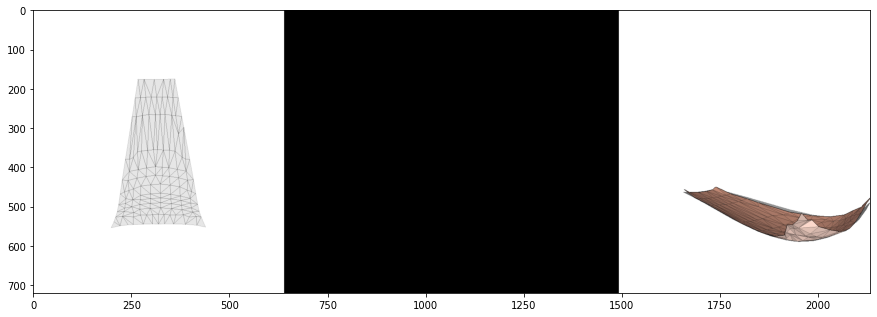

In [42]:
!xvfb-run -e /dev/stdout -s "-screen 0 2560x1440x24 -ac +extension GLX +render -noreset" python visualize.py

import pathlib
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

frames = []
for bmp_file in sorted(list(pathlib.Path(vis_directory).glob('*.bmp'))):
    frames.append(plt.imread(bmp_file))
    #print(bmp_file)
    
from matplotlib import animation, rc
from IPython.display import HTML

plt.rcParams["figure.figsize"] = (15,15)

fig = plt.figure()

ims = []
for i in range(len(frames)):
    im = plt.imshow(frames[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

rc('animation', html='jshtml')
ani

In [ ]:
ani.save('apb.mp4')

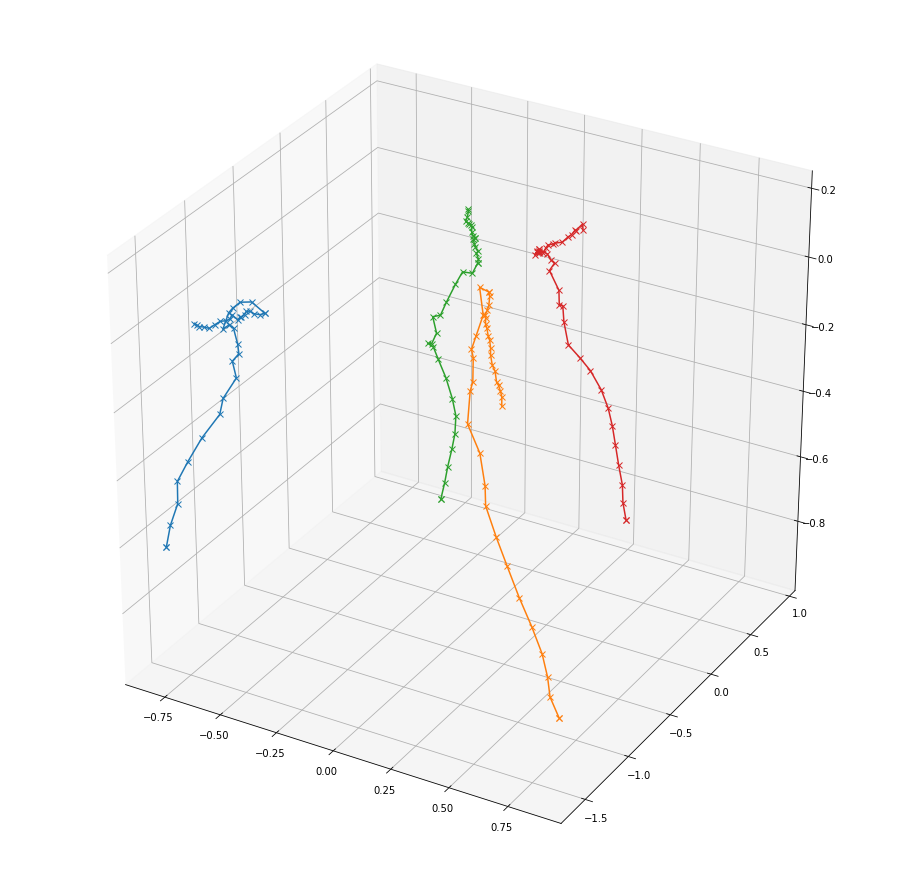

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection = '3d')

for i in range(len(handles)):
    trajectory = (np.cumsum(phase3_v.detach().numpy()[:,i,:]*0.125,axis=0) + flat_mesh.vertices[handles[i]]).T
    ax.plot(trajectory[0], trajectory[1], trajectory[2], marker = 'x')

plt.show()

In [10]:
scene = trimesh.Scene(base_frame='world')

flat_mesh.visual.vertex_colors = [209, 158, 135, 255]
f_id = scene.add_geometry(flat_mesh)
c_id = scene.add_geometry(curved_mesh)

steps = 40

trajectories = []

for handle in handles:
    ray_origin = flat_mesh.vertices[handle]
    
    ray_direction = curved_mesh.vertices[handle] - flat_mesh.vertices[handle]
    ray_direction = ray_direction

    locations, index_ray, index_tri = curved_mesh.ray.intersects_location(
        ray_origins=np.array([ray_origin]),
        ray_directions=np.array([ray_direction]))

    location = locations[0]
    path = np.dstack([np.linspace(ray_origin[0],location[0],steps),np.linspace(ray_origin[1],location[1],steps),np.linspace(ray_origin[2],location[2],steps)])

    path = path.squeeze()
    trajectories.append(path)

trajectories = np.array(trajectories) #this is positions, not vs
trajectories = np.diff(trajectories,axis=1) #vs
trajectories = trajectories.transpose(1,0,2)
trajectories = np.concatenate([trajectories,np.expand_dims(np.zeros_like(trajectories[0]),0)])
trajectories_torch = torch.tensor(trajectories)


path = np.load('positions.npy')

for i in range(len(handles)):
    #original_path = trimesh.load_path(np.cumsum(trajectories[:,i,:],axis=0) + flat_mesh.vertices[handles[i]])
    #scene.add_geometry(original_path)
    #optimized_path = trimesh.load_path(np.cumsum(phase3_v.detach().numpy()[:-2,i,:]*0.125,axis=0) + flat_mesh.vertices[handles[i]])
    #scene.add_geometry(optimized_path)
    scene.add_geometry(trimesh.load_path(path[:,i,:]))


scene.show()

In [11]:
def ring_metric(sim, rings,thresh = 5e-3):

    dists = []
    for i in range(len(sim.cloths[0].mesh.nodes)):
        dists.append(torch.dot(sim.cloths[0].mesh.nodes[i].x - torch_tool_v[i],torch_tool_n[i]))

    #n_dists = torch.einsum('ij,ij->i', torch_fabric_v - torch_tool_v, torch_tool_n)

    n_dists = torch.stack(dists)
    pos_n_dists = torch.nn.functional.relu(n_dists)
    # weights = torch.exp(-pos_n_dists/thresh)

    contact_mean = torch.zeros(len(rings))
    contact_min = torch.zeros(len(rings))


    for i in range(len(rings)):
        contact_mean[i] = pos_n_dists[rings[i]].mean()
        contact_min[i] = pos_n_dists[rings[i]].min()

    return contact_mean, contact_min

In [16]:
def phase4_sim(sim,param_v, pre_steps, steps):

  positions = np.zeros((steps,4,3),dtype=np.float64)

  phase1 = torch.load('phase1.pt')
  phase2 = torch.load('phase2.pt')
  param_v = torch.cat([phase1,phase2],dim=0)

  dists = np.zeros((steps,),dtype=np.float64)
  contact_loss = np.zeros((steps,),dtype=np.float64)
  ring_metric_value_mean = np.zeros((steps,len(rings)),dtype=np.float64)
  ring_metric_value_min = np.zeros((steps,len(rings)),dtype=np.float64)


  linear = False

  print("step")
  for step in range(pre_steps + steps):

    if step > pre_steps-1:
      for i in range(len(handles)):
        if linear:
          sim.cloths[0].mesh.nodes[handles[i]].v += trajectories_torch[step-pre_steps,i] * 8.0
        else:
          sim.cloths[0].mesh.nodes[handles[i]].v += param_v[step-pre_steps,i]
        positions[step-pre_steps,i] = sim.cloths[0].mesh.nodes[handles[i]].x.detach().numpy()

      # step_contact_loss = total_contact_loss_dist_normal(sim,[],5e-3)
      # step_contact_loss = ring_contact_loss_normal(sim,rings)
      # contact_loss[step-pre_steps] = step_contact_loss
      # print(step_contact_loss)
      # step_seed_pt_dist = torch.dot(sim.cloths[0].mesh.nodes[seed_pt_idx].x - torch_tool_v[seed_pt_idx],torch_tool_n[seed_pt_idx])
      # dists[step-pre_steps] = step_seed_pt_dist.detach().numpy()

      mean,min = ring_metric(sim,rings)
      ring_metric_value_mean[step-pre_steps,:] = mean.detach().numpy()
      ring_metric_value_min[step-pre_steps,:] = min.detach().numpy()
      #print(step_seed_pt_dist)
  
    arcsim.sim_step()

  if linear:
    prefix = 'linear'
  else:
    prefix = 'planned'

  np.save(f'{prefix}_positions.npy', positions)
  np.save(f'{prefix}_contact_loss.npy', contact_loss)
  np.save(f'{prefix}_seed_pt_distances.npy', dists)
  np.save(f'{prefix}_ring_metric_value_mean.npy', ring_metric_value_mean)
  np.save(f'{prefix}_ring_metric_value_min.npy', ring_metric_value_min)

  return torch.norm(sim.cloths[0].mesh.nodes[seed_pt_idx].x - torch_tool_v[i])

In [17]:
phase4_config = {
    'lr':0.01,
    'run_sim':phase4_sim,
    'epochs':0,
    'pre_steps':5,
    'steps':40,
    'out_path' : '/content/double_hump_draping_phase4_out',
    'json_config' : f"""
    {{
    "frame_time": 0.125,
    "frame_steps": 1,
    "end_time": 10,
    "cloths": [
    {{
        "mesh": "{inital_fabric_mesh_path}",
        "transform":{{"scale":{scale},"translate":{fabric_t}}},
        "materials": [{{"data": "materials/gray-interlock.json",
                       "thicken": 2}}]
    }}
    ],
    "obstacles": [
    {{
        "mesh": "{tool_mesh_path}",
        "transform":{{"scale":{scale},"translate":{tool_t}}},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }}
    ],
    "disable":["remeshing", "proximity"],
    "handles": [{{"nodes": {handles}}}],
    "gravity":[0, 0, -9.8],
    "magic": {{"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}}
    }}"""
}

In [18]:
_ = run(phase4_config)

step
new best


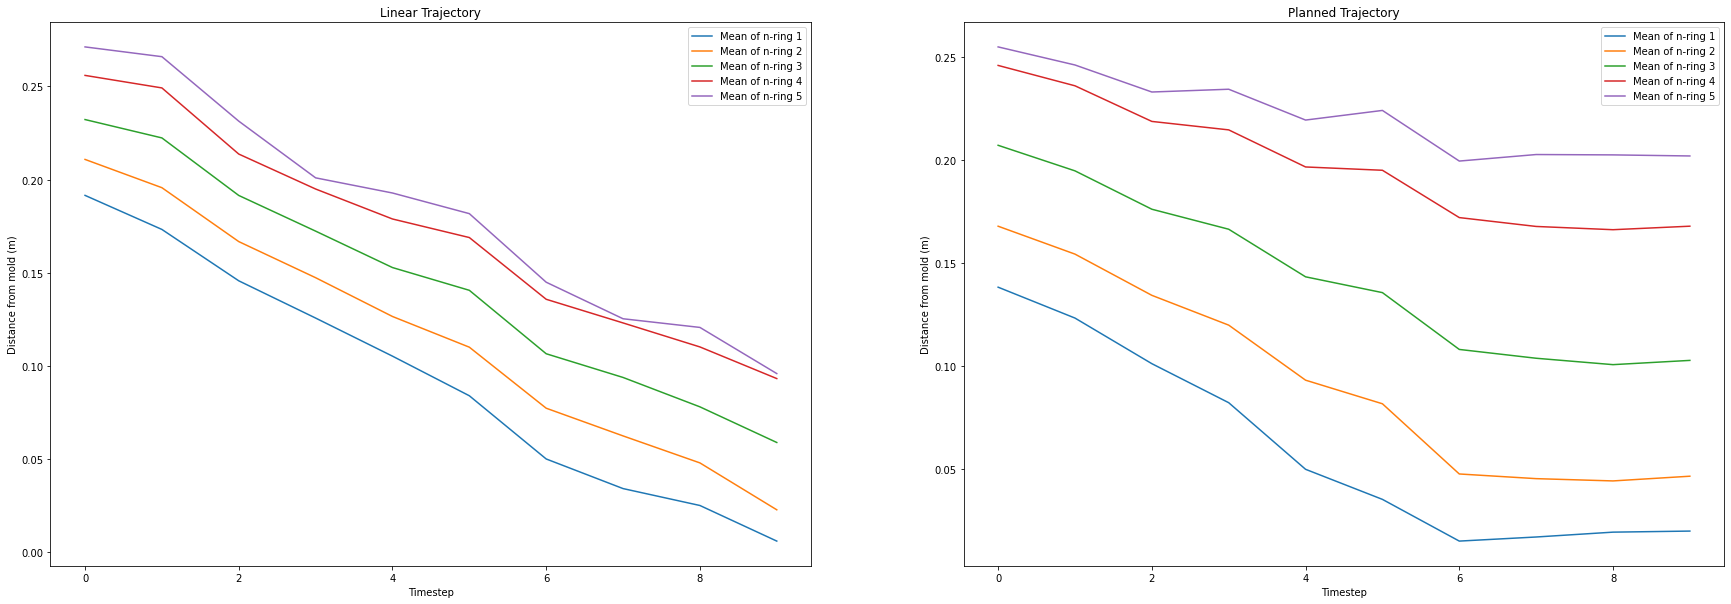

In [38]:
linear_metrics_mean = np.load('linear_ring_metric_value_mean.npy')
optimized_metrics_mean = np.load('planned_ring_metric_value_mean.npy')

plt.figure(figsize=(30,10))
plt.subplot(1, 2, 1)
plt.plot(linear_metrics_mean[5:15,0:5]) #we dont plot the final edge ring because the handle distances are not relevant
plt.gca().legend(('Mean of n-ring 1','Mean of n-ring 2','Mean of n-ring 3','Mean of n-ring 4','Mean of n-ring 5','Mean of n-ring 6','Mean of n-ring 7','Mean of n-ring 8'))
plt.xlabel('Timestep')
plt.ylabel('Distance from mold (m)')
plt.title('Linear Trajectory')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.plot(optimized_metrics_mean[5:15,0:5]) #we dont plot the final edge ring because the handle distances are not relevant
plt.gca().legend(('Mean of n-ring 1','Mean of n-ring 2','Mean of n-ring 3','Mean of n-ring 4','Mean of n-ring 5','Mean of n-ring 6','Mean of n-ring 7','Mean of n-ring 8'))
plt.xlabel('Timestep')
plt.ylabel('Distance from mold (m)')
plt.title('Planned Trajectory')
plt.grid(False)


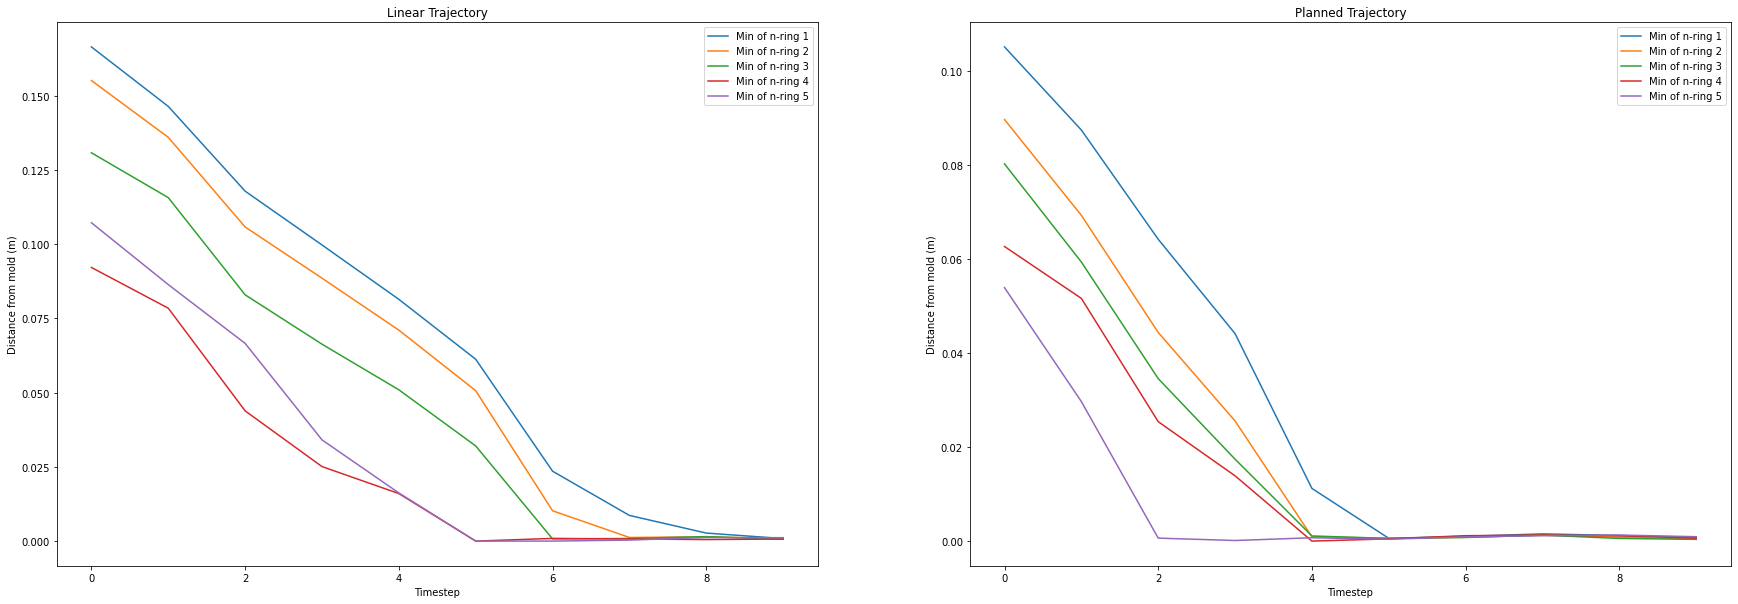

In [37]:
import matplotlib.pyplot as plt
linear_metrics_min = np.load('linear_ring_metric_value_min.npy')
optimized_metrics_min = np.load('planned_ring_metric_value_min.npy')

plt.figure(figsize=(30,10))
plt.subplot(1, 2, 1)
plt.plot(linear_metrics_min[5:15,0:5]) #we dont plot the final edge ring because the handle distances are not relevant
plt.gca().legend(('Min of n-ring 1','Min of n-ring 2','Min of n-ring 3','Min of n-ring 4','Min of n-ring 5','Min of n-ring 6','Min of n-ring 7','Min of n-ring 8'))
plt.xlabel('Timestep')
plt.ylabel('Distance from mold (m)')
plt.title('Linear Trajectory')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.plot(optimized_metrics_min[5:15,0:5]) #we dont plot the final edge ring because the handle distances are not relevant
plt.gca().legend(('Min of n-ring 1','Min of n-ring 2','Min of n-ring 3','Min of n-ring 4','Min of n-ring 5','Min of n-ring 6','Min of n-ring 7','Min of n-ring 8'))
plt.xlabel('Timestep')
plt.ylabel('Distance from mold (m)')
plt.title('Planned Trajectory')
plt.grid(False)


In [23]:
optimized_positions = np.load('planned_positions.npy')[35:40]
linear_positions = np.load('linear_positions.npy')[35:40]
target_positions = np.array([curved_mesh.vertices[handles[0]],curved_mesh.vertices[handles[1]],curved_mesh.vertices[handles[2]],curved_mesh.vertices[handles[3]]])

In [24]:
np.mean(linear_positions - target_positions,axis=2)

array([[ 0.03846007, -0.01397121, -0.02333945, -0.05442986],
       [ 0.03529035, -0.01825718, -0.02392124, -0.05628667],
       [ 0.03213053, -0.02252344, -0.02445777, -0.05816244],
       [ 0.02898038, -0.02676187, -0.02518711, -0.0595626 ],
       [ 0.02584422, -0.03096213, -0.02634414, -0.0604837 ]])

In [25]:
np.mean(np.mean(linear_positions - target_positions,axis=2)[4])

-0.02298644138259761

In [26]:
np.mean(optimized_positions - target_positions,axis=2)

array([[ 0.00041525,  0.02534203, -0.00040084,  0.00554631],
       [-0.00590524,  0.03506   , -0.00216849, -0.0001005 ],
       [ 0.00161541,  0.04016311, -0.00291287, -0.00089752],
       [-0.00197565,  0.03824044, -0.00249533, -0.00868234],
       [ 0.00882772,  0.0428396 ,  0.00027752, -0.00902072]])

In [29]:
np.mean(np.mean(optimized_positions - target_positions,axis=2)[4])

0.01073103147547147

In [34]:
scene = trimesh.Scene(base_frame='world')

# flat_mesh.visual.vertex_colors = [209, 158, 135, 255]
flat_mesh.visual.vertex_colors = [0, 0, 0, 255]


f_id = scene.add_geometry(flat_mesh)
c_id = scene.add_geometry(curved_mesh)

ring_colours = [[31,119,180],[255,127,14],[44,160,44],[214,39,40],[148,103,189]]

for i in range(0,5):
  for j in rings[i]:
    p = trimesh.creation.icosphere(radius=0.025)
    p.apply_translation(flat_mesh.vertices[j])
    p.visual.vertex_colors = ring_colours[i-1]
    scene.add_geometry(p)
  # p = trimesh.points.PointCloud(vertices = flat_mesh.vertices[rings[i]], colors=ring_colours[i-1])
  # scene.add_geometry(p)

steps = 40

trajectories = []

for handle in handles:
    ray_origin = flat_mesh.vertices[handle]
    
    ray_direction = curved_mesh.vertices[handle] - flat_mesh.vertices[handle]
    ray_direction = ray_direction

    locations, index_ray, index_tri = curved_mesh.ray.intersects_location(
        ray_origins=np.array([ray_origin]),
        ray_directions=np.array([ray_direction]))

    location = locations[0]
    path = np.dstack([np.linspace(ray_origin[0],location[0],steps),np.linspace(ray_origin[1],location[1],steps),np.linspace(ray_origin[2],location[2],steps)])

    path = path.squeeze()
    trajectories.append(path)

trajectories = np.array(trajectories) #this is positions, not vs
trajectories = np.diff(trajectories,axis=1) #vs
trajectories = trajectories.transpose(1,0,2)
trajectories = np.concatenate([trajectories,np.expand_dims(np.zeros_like(trajectories[0]),0)])
trajectories_torch = torch.tensor(trajectories)

path = np.load('positions.npy')

for i in range(len(handles)):
    original_path = trimesh.load_path(np.cumsum(trajectories[:,i,:],axis=0) + flat_mesh.vertices[handles[i]])
    scene.add_geometry(original_path)
    #optimized_path = trimesh.load_path(np.cumsum(phase3_v.detach().numpy()[:-2,i,:]*0.125,axis=0) + flat_mesh.vertices[handles[i]])
    #scene.add_geometry(optimized_path)
    scene.add_geometry(trimesh.load_path(path[:,i,:]))


scene.show()